In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [2]:
# ============================================
# 1. Load and clean data
# ============================================

target = "Sales"

df = pd.read_csv("Superstore.csv", encoding="latin1")

# Fix whitespace and convert dates
df.columns = df.columns.str.strip()

df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")
df["Ship Date"] = pd.to_datetime(df["Ship Date"], errors="coerce")

numeric_candidates = ["Sales", "Quantity", "Discount", "Profit"]
for col in numeric_candidates:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.drop_duplicates()

# Drop rows missing target
df = df.dropna(subset=[target])

df = df.dropna(subset=["Order Date"])

# For numeric columns: replace inf and handle remaining NaN
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)

# Fill remaining numeric NaNs with median (robust)
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Remove negative or zero quantities (likely data errors)
if "Quantity" in df.columns:
    df = df[df["Quantity"] > 0]

# Sales should be non-negative
if "Sales" in df.columns:
    df = df[df["Sales"] >= 0]

# Discount should be between 0 and 1 (clip crazy values)
if "Discount" in df.columns:
    df["Discount"] = df["Discount"].clip(lower=0.0, upper=1.0)

# Remove absurd shipping lags if you've already computed them
if "Ship Date" in df.columns and "Order Date" in df.columns:
    ship_lag = (df["Ship Date"] - df["Order Date"]).dt.days
# keep orders with -2 to 60 days lag (tweak as you like)
    mask = ship_lag.between(-2, 60)
    df = df[mask]


# Robust outlier capping (1st–99th pct)
# Select numeric columns and exclude the target (Sales)
num_cols_for_outliers = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols_for_outliers = [c for c in num_cols_for_outliers if c != target]

# Clip each numeric feature between its 1st and 99th percentile
for col in num_cols_for_outliers:
    q_low = df[col].quantile(0.01)
    q_high = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=q_low, upper=q_high)

print("\nApplied 1st–99th percentile capping to numeric features (excluding target).")

display(df)



Applied 1st–99th percentile capping to numeric features (excluding target).


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,100.93,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.913600
1,100.93,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.582000
2,100.93,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.871400
3,100.93,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-319.264953
4,100.93,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.516400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9894.07,CA-2014-110422,2014-01-21,2014-01-23,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.102800
9990,9894.07,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.633200
9991,9894.07,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.393200
9992,9894.07,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.320000


In [3]:
def correlation_heatmap(df, title):
    """Compute and display a correlation heatmap from numeric columns."""
    numeric_df = df.select_dtypes(include=[np.number])
    
    corr = numeric_df.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr,
        cmap="coolwarm",
        annot=True,      
        fmt=".2f",       
        square=True,
        cbar=True
    )
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()


Showing correlation BEFORE dropping leakage columns...



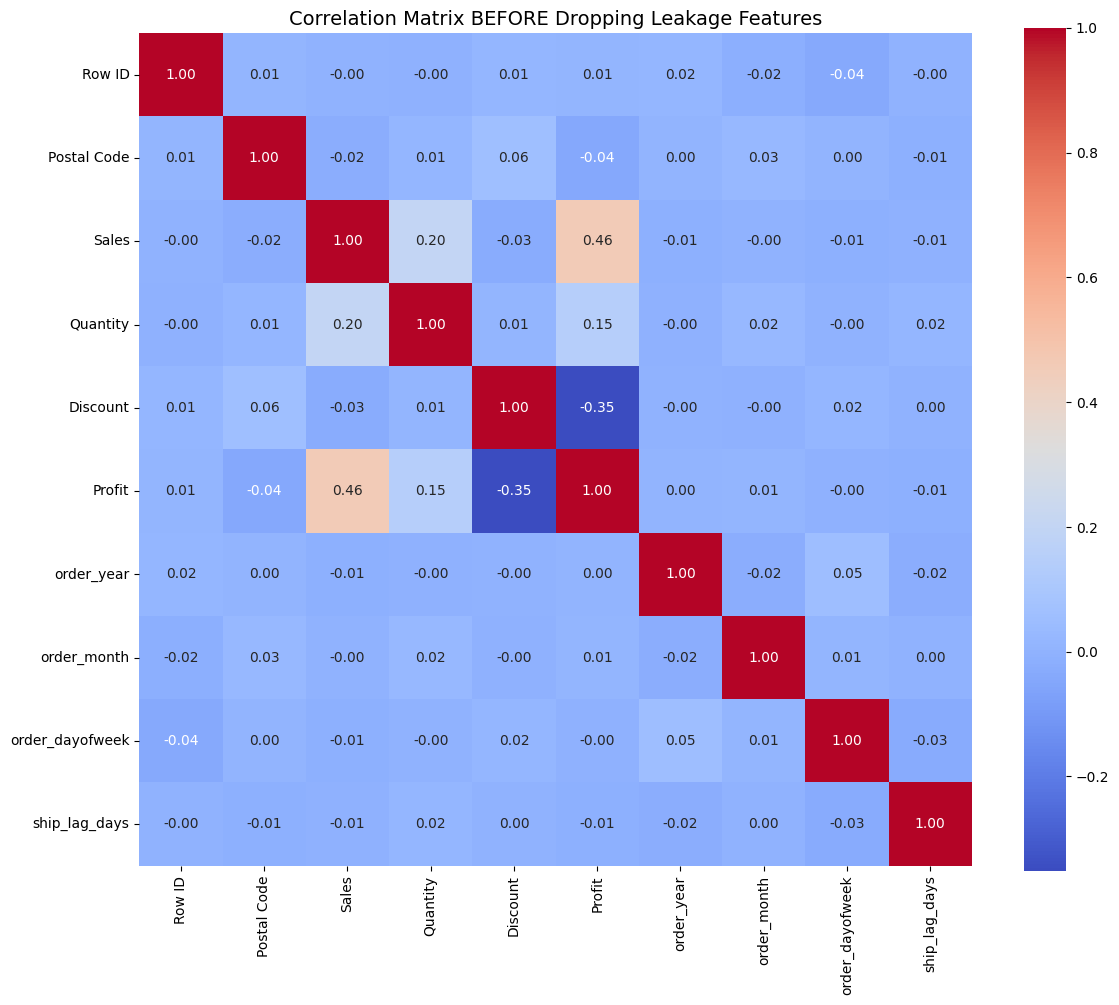


Dropped columns: ['City', 'Postal Code', 'Row ID', 'Order ID', 'Customer ID', 'Customer Name', 'Product ID', 'Product Name', 'Order Date', 'Ship Date', 'Sales', 'Profit', 'Country']

Showing correlation AFTER dropping leakage columns...



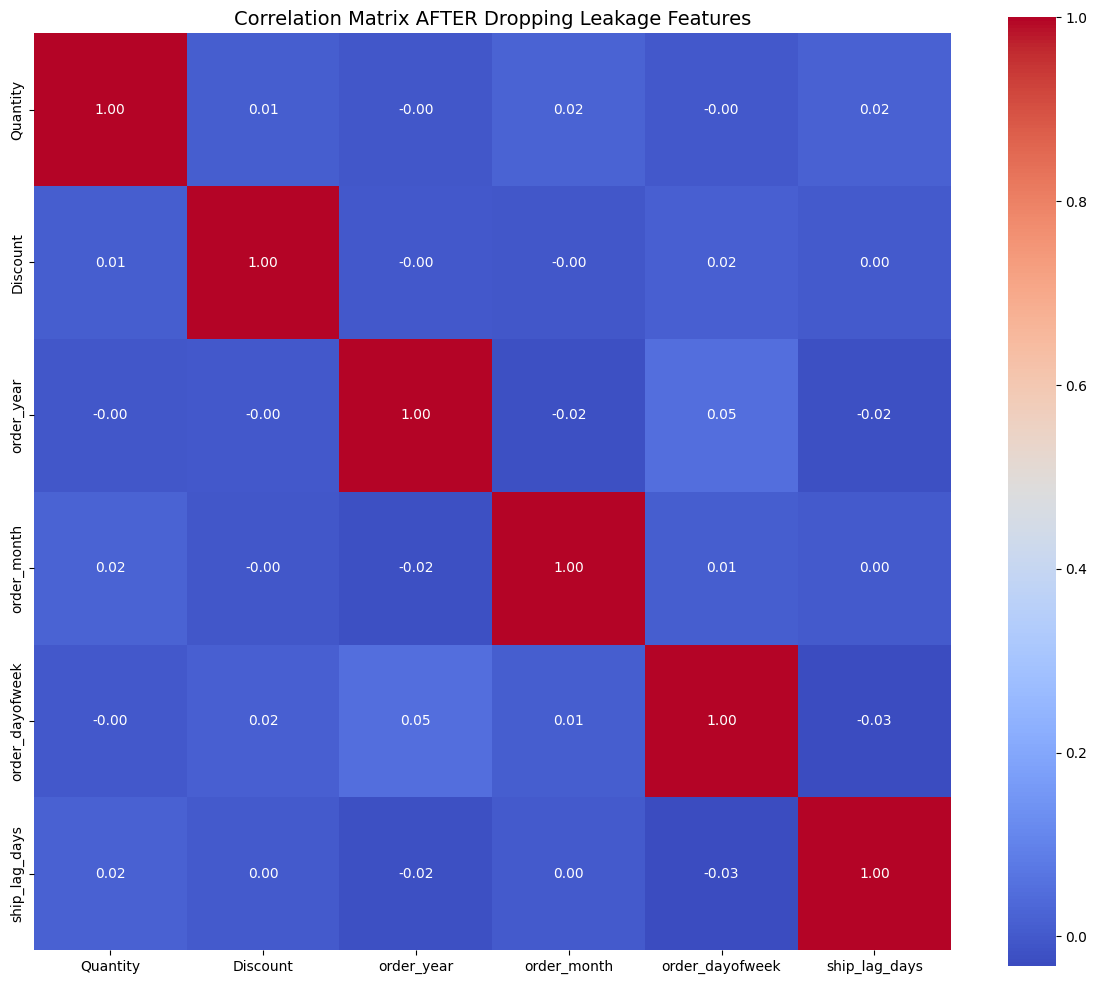

,Ship Mode,Segment,State,Region,Category,Sub-Category,Quantity,Discount,order_year,order_month,order_dayofweek,ship_lag_days
0,Standard Class,Consumer,Texas,Central,Office Supplies,Paper,2,0.2,2014,1,4,4
1,Standard Class,Home Office,Illinois,Central,Office Supplies,Labels,3,0.2,2014,1,5,4
2,Standard Class,Home Office,Illinois,Central,Office Supplies,Storage,3,0.2,2014,1,5,4
3,Standard Class,Home Office,Illinois,Central,Office Supplies,Binders,2,0.8,2014,1,5,4
4,Standard Class,Consumer,Pennsylvania,East,Office Supplies,Art,3,0.2,2014,1,6,7
...,...,...,...,...,...,...,...,...,...,...,...,...
9989,Standard Class,Consumer,Colorado,West,Office Supplies,Fasteners,3,0.2,2017,12,5,4
9990,Standard Class,Consumer,New York,East,Office Supplies,Binders,3,0.2,2017,12,5,4
9991,Standard Class,Consumer,New York,East,Technology,Phones,7,0.0,2017,12,5,4
9992,Standard Class,Corporate,California,West,Office Supplies,Binders,2,0.2,2017,12,5,4


0        16.448
1        11.784
2       272.736
3         3.540
4        19.536
         ...   
9989      3.024
9990     52.776
9991     90.930
9992     13.904
9993    323.136
Name: Sales, Length: 9994, dtype: float64

In [4]:
# ============================================
# 2. Feature Engineering
# ============================================
df["order_year"] = df["Order Date"].dt.year
df["order_month"] = df["Order Date"].dt.month
df["order_dayofweek"] = df["Order Date"].dt.dayofweek
df["ship_lag_days"] = (df["Ship Date"] - df["Order Date"]).dt.days


# Fix infinite or NaN
df = df.replace([np.inf, -np.inf], np.nan)


print("Showing correlation BEFORE dropping leakage columns...\n")

correlation_heatmap(
    df, 
    title="Correlation Matrix BEFORE Dropping Leakage Features"
)

# sort df by Order Date for creating X_test from the latest portion
df = df.sort_values("Order Date")  
df = df.reset_index(drop=True)

# ============================================
# 3. Prepare X and y for regression
# ============================================


drop_cols = [
    "City","Postal Code", "Row ID", "Order ID",
    "Customer ID", "Customer Name",
    "Product ID", "Product Name",
    "Order Date", "Ship Date", 
    "Sales", "Profit", "Country"    
      
]



df_clean = df.drop(columns=drop_cols, errors="ignore")

print("\nDropped columns:", drop_cols)


# ============================
# 3. CORRELATION AFTER DROP
# ============================

print("\nShowing correlation AFTER dropping leakage columns...\n")

correlation_heatmap(
    df_clean,
    title="Correlation Matrix AFTER Dropping Leakage Features"
)

X = df_clean
y = df[target]

display(X)
display(y)

In [5]:
# # Identify categorical and numeric columns
# cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
# num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# # One-hot encode for RandomForest ONLY
# X_rf = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# # CatBoost works with raw categorical strings
# X_cb = X.copy()

# # Train-test split
# X_train_rf, X_test_rf, y_train_O, y_test_O = train_test_split(
#     X_rf, y, test_size=0.2, random_state=42
# )

# y_train = np.log1p(y_train_O)
# y_test = np.log1p(y_test_O)


# X_train_cb, X_test_cb, _, _ = train_test_split(
#     X_cb, y, test_size=0.2, random_state=42
# )

In [6]:
# # -----------------------
# # Random Forest grid
# # -----------------------
# rf = RandomForestRegressor(random_state=42)

# rf_param_grid = {
#     "n_estimators": [200, 400],
#     "max_depth": [15],
#     "min_samples_split": [2, 5],
#     "min_samples_leaf": [1, 2],
#     "max_features": ["sqrt", 0.7],
#     "bootstrap": [True]
# }

# rf_grid = GridSearchCV(
#     estimator=rf,
#     param_grid=rf_param_grid,
#     scoring="neg_root_mean_squared_error",  # RMSE
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

# rf_grid.fit(X_train_rf, y_train)

# print("\nBest RF params:", rf_grid.best_params_)
# print("Best RF CV RMSE:", -rf_grid.best_score_)

# best_rf = rf_grid.best_estimator_

# rf_pred = best_rf.predict(X_test_rf)
# rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
# rf_r2 = r2_score(y_test, rf_pred)

# print("\n=== RandomForest (test set) ===")
# print("RMSE:", rf_rmse)
# print("R²  :", rf_r2)


In [7]:
# # `cat_cols` = list of categorical column names in *original* X (before one-hot)
# # If you used one-hot for RF but raw categoricals for CatBoost,
# # you should have something like:
# # cat_cols = X_cb.select_dtypes(include=["object"]).columns.tolist()

# cb = CatBoostRegressor(
#     loss_function="RMSE",
#     random_seed=42,
#     verbose=0
# )

# cb_param_grid = {
#     "depth": [6, 8],
#     "learning_rate": [0.03, 0.06],
#     "iterations": [600, 1000],
#     "l2_leaf_reg": [3, 6],
#     "bagging_temperature": [0.2, 1.0]
# }

# cb_grid = GridSearchCV(
#     estimator=cb,
#     param_grid=cb_param_grid,
#     scoring="neg_root_mean_squared_error",
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

# # IMPORTANT: use the version of X with raw categoricals (no one-hot)
# cb_grid.fit(X_train_cb, y_train, cat_features=[
#     X_train_cb.columns.get_loc(c) for c in X_train_cb.columns if c in cat_cols
# ])

# print("\nBest CatBoost params:", cb_grid.best_params_)
# print("Best CatBoost CV RMSE:", -cb_grid.best_score_)

# best_cb = cb_grid.best_estimator_

# cb_pred = best_cb.predict(X_test_cb)
# cb_rmse = np.sqrt(mean_squared_error(y_test, cb_pred))
# cb_r2 = r2_score(y_test, cb_pred)

# print("\n=== CatBoost (test set) ===")
# print("RMSE:", cb_rmse)
# print("R²  :", cb_r2)


In [8]:
# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# One-hot encode for RandomForest ONLY
X_rf = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# CatBoost works with raw categorical strings
X_cb = X.copy()

test_size = 0.2
n = len(X_rf)
split_idx = int(n * (1 - test_size))   # 80% train, 20% test

# manual time-based split (no random shuffling)
# RandomForest matrices
X_train_rf = X_rf.iloc[:split_idx]
X_test_rf  = X_rf.iloc[split_idx:]

# CatBoost matrices (same rows)
X_train_cb = X_cb.iloc[:split_idx]
X_test_cb  = X_cb.iloc[split_idx:]

# Targets aligned with the same split
y_train_O = y.iloc[:split_idx]
y_test_O  = y.iloc[split_idx:]

# Log-transform (if you still want that)
y_train = np.log1p(y_train_O)
y_test  = np.log1p(y_test_O)


In [9]:
# ============================================
# 4. Train RandomForestRegressor
# ============================================
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=15,
    random_state=42,
    bootstrap=True,
    max_features=0.7,
    min_samples_leaf=2,
    min_samples_split=5
)

rf.fit(X_train_rf, y_train)
pred_rf = rf.predict(X_test_rf)

rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
r2_rf = r2_score(y_test, pred_rf)

In [10]:
# ============================================
# 5. Train CatBoostRegressor
# ============================================
model_cb = CatBoostRegressor(
    iterations=600,
    depth=6,
    learning_rate=0.03,
    loss_function="RMSE",
    l2_leaf_reg=6,
    random_state=42,
    verbose=False,
    bagging_temperature=0.2
)


model_cb.fit(
    X_train_cb,
    y_train,
    cat_features=cat_cols
)

pred_cb = model_cb.predict(X_test_cb)

rmse_cb = np.sqrt(mean_squared_error(y_test, pred_cb))
r2_cb = r2_score(y_test, pred_cb)


In [11]:
# ============================================
# 6. Compare Performance
# ============================================
print("========== MODEL PERFORMANCE COMPARISON ==========")
print(f"RandomForest RMSE: {rmse_rf:.2f}")
print(f"RandomForest R²:   {r2_rf:.4f}")
print("--------------------------------------------------")
print(f"CatBoost RMSE:     {rmse_cb:.2f}")
print(f"CatBoost R²:       {r2_cb:.4f}")

# ============================================
# 7. Feature Importance (top 15)
# ============================================
print("\n========== Top 15 CatBoost Feature Importances ==========")
print(model_cb.get_feature_importance(prettified=True).head(15))

print("\n========== RandomForest Feature Importances (top 15) ==========")
rf_importances = pd.DataFrame({
    "feature": X_rf.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

print(rf_importances.head(15))

========== MODEL PERFORMANCE COMPARISON ==========
RandomForest RMSE: 1.05
RandomForest R²:   0.5476
--------------------------------------------------
CatBoost RMSE:     1.03
CatBoost R²:       0.5640

========== Top 15 CatBoost Feature Importances ==========
         Feature Id  Importances
0      Sub-Category    42.531408
1          Quantity    30.842276
2          Discount    10.345705
3          Category     8.341836
4             State     1.945995
5         Ship Mode     1.312621
6           Segment     1.207137
7       order_month     1.045261
8            Region     1.020160
9   order_dayofweek     0.627584
10    ship_lag_days     0.535271
11       order_year     0.244746

========== RandomForest Feature Importances (top 15) ==========
                     feature  importance
62  Category_Office Supplies    0.237651
0                   Quantity    0.162957
72  Sub-Category_Furnishings    0.081876
77      Sub-Category_Storage    0.078432
1                   Discount    0.044575